# Super Resolution on Pet Images using UNet and Perceptual Loss

We will train a UNet network to improve the resolution and detail of low quality images. 

The UNet architecture is ideal when your neural network's outputs are the same size as, or similar in size to its inputs. In this case, we're both inputting and outputting images, and we want our output images to be as similar as possible to the corresponding input images, only sharper and more detailed.

Before UNet was invented, practitioners would build an encoder network that accepted the image inputs, and connect it to a decoder network that would output the cleaned-up images. However, results were often poor because too much information about the original images' appearances was lost in the final layers of the encoder network, as these layers' receptive field sizes were much smaller than the original image.

![https://tuatini.me/content/images/2017/09/u-net-architecture-1.png](images/lesson7-superres-my-reimplementation/unet_arch.png)

[UNet's innovation](https://arxiv.org/abs/1505.04597) is that at each layer of the decoder network, weights from the corresponding layer of the encoder network are concatenated. The result of this is that the final layers of the decoder "know" a whole lot more about the intricacies of the original input image. This means that the decocoder can produce images are not only sharper, but that also really do resemble the original input images.

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

## Preparing the dataset

In this notebook we'll use images from the pet images dataset. We first need to take the original images and shrink them to a lower resolution. 

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [44]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-96'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')]

A list containing all the original pet images.

In [4]:
il = ImageItemList.from_folder(path_hr)

A function that resizes our original pet images down to 96 px and stores them in the appropriate directory.

In [5]:
def resize_one(fn, i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [7]:
# Uncomment if running this notebook for the first time.
# parallel(resize_one, il.items)

We'll first train by using the original images resized down to 128 px to serve as our target images. Later on, we'll resize them to 256 px in order to fine-tune. 

In other words, we'll start by training our model to improve the resolution of 96 px images to a resolution of 128 px. Later on, we'll teach our model to be able to take a 96 px image and scale it up 256 px and add in all the necessary detail and definition.

In [6]:
bs = 32 # batch size
size = 128
arch = models.resnet34 # use transfer learning

Let's set aside 10 percent of the images to serve as the validation set.

In [7]:
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

Use fastai's data block API to specify preprocessing, output image size, augmentation, etc.

In [8]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    
    data.c=3
    return data

In [9]:
data = get_data(bs, size)

As a quick sanity check, we'll display a couple of images from the validation set. 

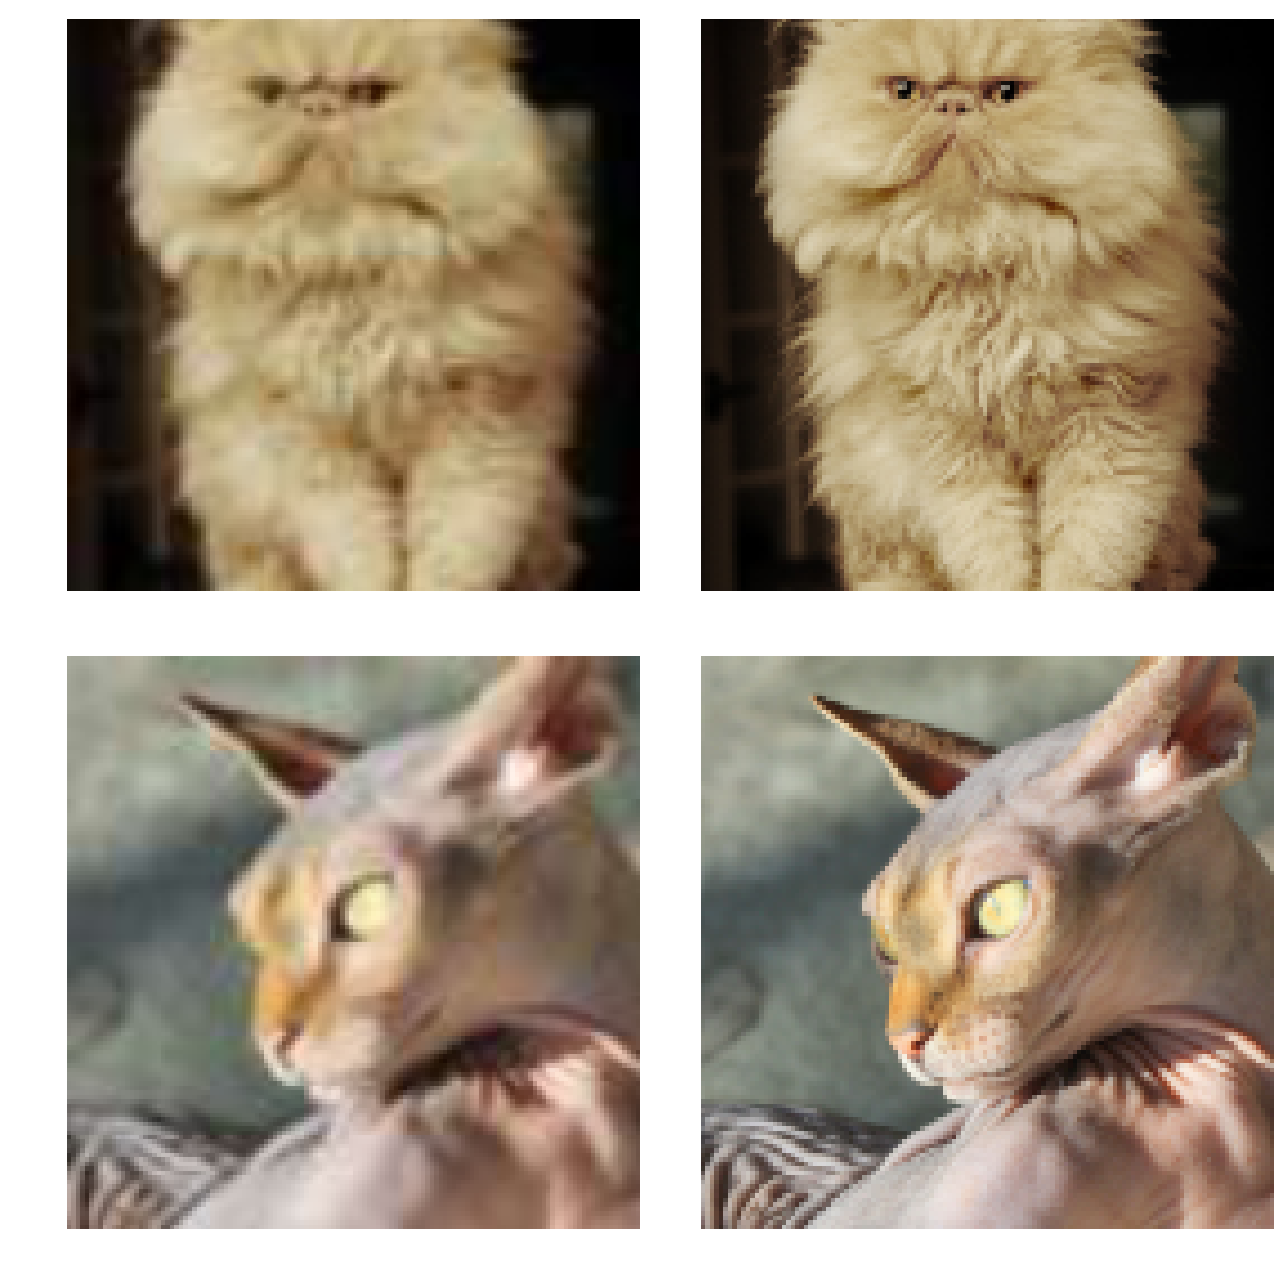

In [51]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

The images on the left are the low-quality 96 px inputs, and the images on the right are the 128 px higher quality versions. We want our model to learn how to generate the images on the right on its own.

## Feature Loss

Our loss function is based on the approach explained in the paper [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155). The idea is to replace per-pixel loss with a perceptual loss.

This loss function is measuring two things:
1. Whether the output images have the right *style* (are they sharp enough).
* Do the output images have the same content as the original input images (eg. if the input image has a cat with big ears, does the output also have a cat with big ears, and are the cat and its ears in the same location in each image).

Becasue our loss function is in part based on whether or not our model is able to apply the right style (sharper details) to the images it produces, we'll use an image's gram matrix to quantitatively represent its style (detailed explanation [here](https://www.amitagrawal.org/blog/2017/12/1/how-does-gram-matrix-encode-the-style-of-an-image)). Below we create a method to calculate this.

In [10]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1) # flatten the image to a 2d vector of length h*w
    return (x @ x.transpose(1,2))/(c*h*w)

Let's see a quick example.

In [11]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [12]:
t

tensor([[[[5.7562e-02, 6.2497e-02, 5.4007e-02,  ..., 1.7690e-06,
           8.0608e-04, 3.8092e-03],
          [5.9865e-02, 6.6529e-02, 5.6295e-02,  ..., 0.0000e+00,
           0.0000e+00, 3.9216e-03],
          [6.5594e-02, 7.0165e-02, 5.8493e-02,  ..., 1.8762e-06,
           0.0000e+00, 3.9216e-03],
          ...,
          [8.2353e-02, 9.1085e-02, 1.1121e-01,  ..., 3.9034e-03,
           1.4527e-05, 1.9608e-03],
          [7.8881e-02, 9.3155e-02, 1.1339e-01,  ..., 3.9216e-03,
           1.1085e-02, 1.2153e-02],
          [7.7560e-02, 8.9524e-02, 1.1141e-01,  ..., 6.4699e-03,
           1.0876e-02, 1.0675e-02]],

         [[3.8179e-02, 4.2890e-02, 3.6501e-02,  ..., 1.7690e-06,
           8.0608e-04, 3.8092e-03],
          [4.0829e-02, 4.2950e-02, 3.7804e-02,  ..., 0.0000e+00,
           0.0000e+00, 3.9216e-03],
          [3.8891e-02, 4.0237e-02, 3.6877e-02,  ..., 1.8762e-06,
           0.0000e+00, 3.9216e-03],
          ...,
          [6.2745e-02, 7.1781e-02, 7.9777e-02,  ..., 3.9034

In [13]:
gram_matrix(t)

tensor([[[0.1143, 0.1004, 0.0741],
         [0.1004, 0.0886, 0.0657],
         [0.0741, 0.0657, 0.0491]],

        [[0.1143, 0.1004, 0.0741],
         [0.1004, 0.0886, 0.0657],
         [0.0741, 0.0657, 0.0491]]])

In [14]:
gram_matrix(t).size()

torch.Size([2, 3, 3])

We'll use L1 loss as our base, per-pixel loss function.

In [11]:
base_loss = F.l1_loss

Finally, we will use a convolutional neural network pretrained for image classification (VGG16 in this case) to define the loss functions that measure perceptual differences in content and style between the input and output images. The loss network's weights remain fixed during the training process. (see top of page 4 in the [paper on arxiv](https://arxiv.org/pdf/1603.08155.pdf))

In [12]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False) # so that we don't update the weights of our loss network

In [13]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

Here we put our whole loss function together. We make use of our `gram_matrix` method, as well as the per-pixel base loss, and VGG16 loss network.

We use PyTorch hooks to "hook" into the layers of our loss network to grab their weights, so that we can create the features of the output and target images (multiply each network layer's weights by the pixel values of each image) and then compare the results for each output/target image pair to see how closely the constructed images approximate their targets.

In [14]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
                             ] + [f'gram_{i}' for i in range(len(layer_ids))]
        
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target)] # per-pixel loss
        self.feat_losses += [base_loss(f_in, f_out)*w
            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)] # feature loss for each of 3 VGG layers we use
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)] # gram matrix feature loss for each of 3 VGG layers we use
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [15]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2]) # use weights at 3 different layers in our VGG loss network

## Training our UNet

In [16]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect;

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


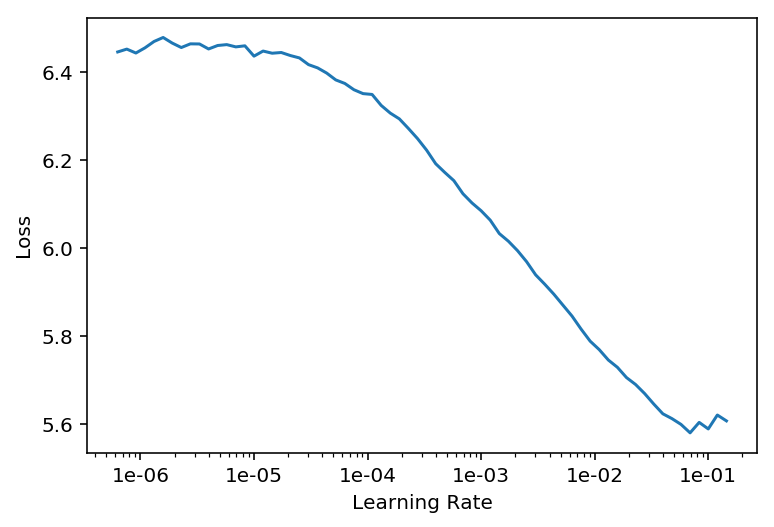

In [63]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr = 1e-3

In [18]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,4.611092,4.489813,0.416604,0.257500,0.355187,0.251958,0.697280,1.359659,1.151626
2,4.243811,4.088396,0.347202,0.246137,0.330730,0.227616,0.624832,1.258340,1.053538
3,3.876072,3.719936,0.207038,0.232385,0.309782,0.215385,0.554052,1.184621,1.016672
4,3.699142,3.539262,0.171189,0.228201,0.302182,0.207404,0.511091,1.138270,0.980924
5,3.631572,3.468112,0.169444,0.225286,0.297859,0.203688,0.496786,1.116275,0.958775
6,3.623501,3.411237,0.153229,0.222305,0.293846,0.200321,0.493871,1.105560,0.942104
7,3.545643,3.402085,0.164037,0.222479,0.291920,0.200082,0.485808,1.093349,0.944411
8,3.544191,3.396063,0.178867,0.221196,0.289492,0.198489,0.480788,1.090497,0.936733
9,3.518600,3.276629,0.154435,0.218245,0.285751,0.193468,0.459364,1.057042,0.908326
10,3.398148,3.159089,0.142124,0.215176,0.277894,0.187808,0.433431,1.019034,0.883622


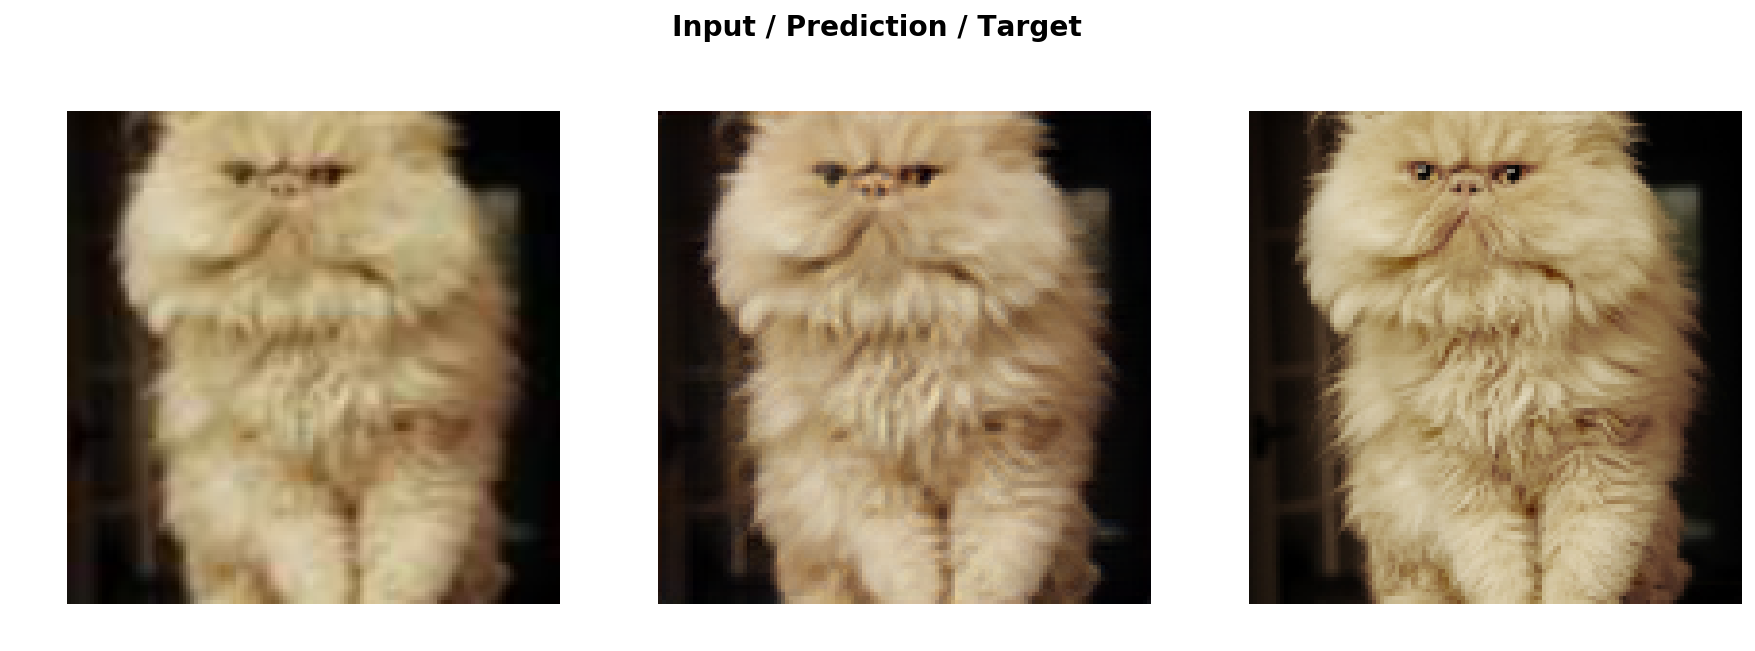

In [66]:
do_fit('1a', slice(lr*10))

After 10 epochs of training the top-most layer weights, we see that our UNet is now able to produce noticeably sharper images (the image labeled `Prediction` above).

As good as this is, it's still not quite as sharp as the original 'Target' image, so let's unfreeze and train some more.

In [25]:
learn.load('1a');

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.347056,3.154268,0.140241,0.214930,0.277478,0.187353,0.434311,1.018810,0.881144
2,3.356783,3.153127,0.145137,0.215271,0.277521,0.186926,0.432085,1.016628,0.879560
3,3.357383,3.139587,0.140940,0.214458,0.276644,0.186416,0.430076,1.013871,0.877181
4,3.352613,3.134259,0.138140,0.214474,0.276230,0.186172,0.428944,1.013859,0.876441
5,3.341285,3.125897,0.138661,0.213630,0.275559,0.185679,0.428224,1.009206,0.874937
6,3.328488,3.137105,0.139628,0.214022,0.275545,0.186174,0.431496,1.011696,0.878545
7,3.324166,3.119314,0.139942,0.213170,0.274720,0.185366,0.425426,1.006633,0.874057
8,3.347088,3.122643,0.139091,0.214252,0.275232,0.185588,0.425003,1.008403,0.875073
9,3.331686,3.116971,0.141948,0.213687,0.274574,0.185410,0.423416,1.005674,0.872262
10,3.315075,3.095104,0.136720,0.213166,0.273690,0.184010,0.420005,1.000364,0.867150


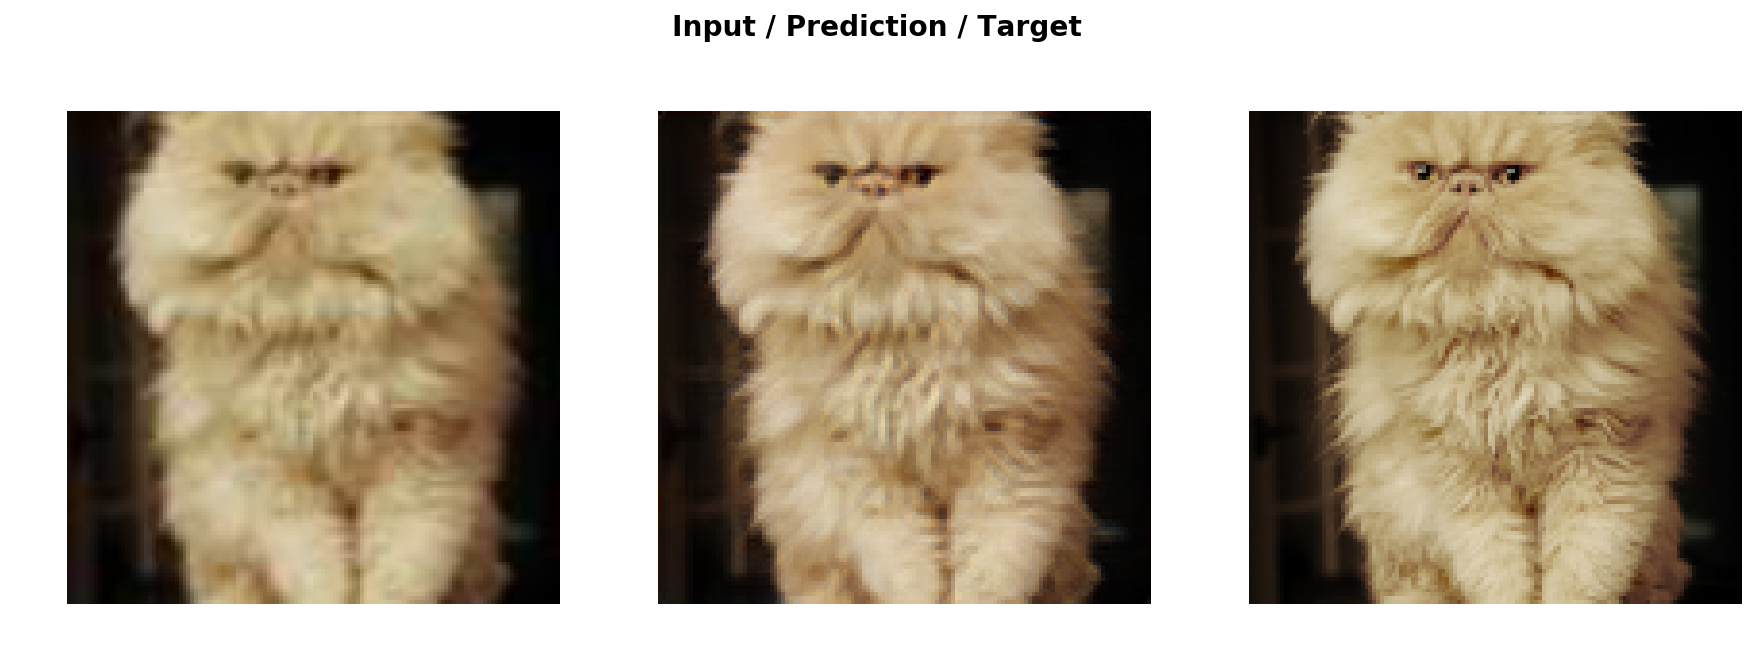

In [27]:
do_fit('1b', slice(1e-5,1e-3))

As promised earlier, let's now increase our target image size by a factor of 2, to 256 px. 

In [20]:
data = get_data(bs//4, size*2)
learn.data = data
learn.load('1b')
learn.freeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.380879,2.196368,0.170184,0.257499,0.291511,0.154206,0.383486,0.576354,0.363128
2,2.351135,2.173761,0.178742,0.258615,0.291320,0.153120,0.366899,0.566829,0.358235
3,2.305761,2.162439,0.186358,0.258097,0.289665,0.151653,0.356681,0.564818,0.355166
4,2.273082,2.121906,0.170388,0.257069,0.286953,0.150627,0.348530,0.556068,0.352270
5,2.250441,2.117616,0.175362,0.256523,0.284675,0.148206,0.349638,0.555086,0.348127
6,2.248897,2.110597,0.176925,0.256902,0.284419,0.148444,0.340567,0.555569,0.347772
7,2.235319,2.129010,0.202137,0.256340,0.284021,0.148202,0.341373,0.549995,0.346941
8,2.236991,2.108314,0.176257,0.256241,0.283190,0.148443,0.343406,0.552595,0.348181
9,2.217657,2.117568,0.203834,0.255568,0.281694,0.145987,0.338648,0.548490,0.343347
10,2.168918,2.065342,0.175689,0.255404,0.279840,0.144976,0.329391,0.540009,0.340034


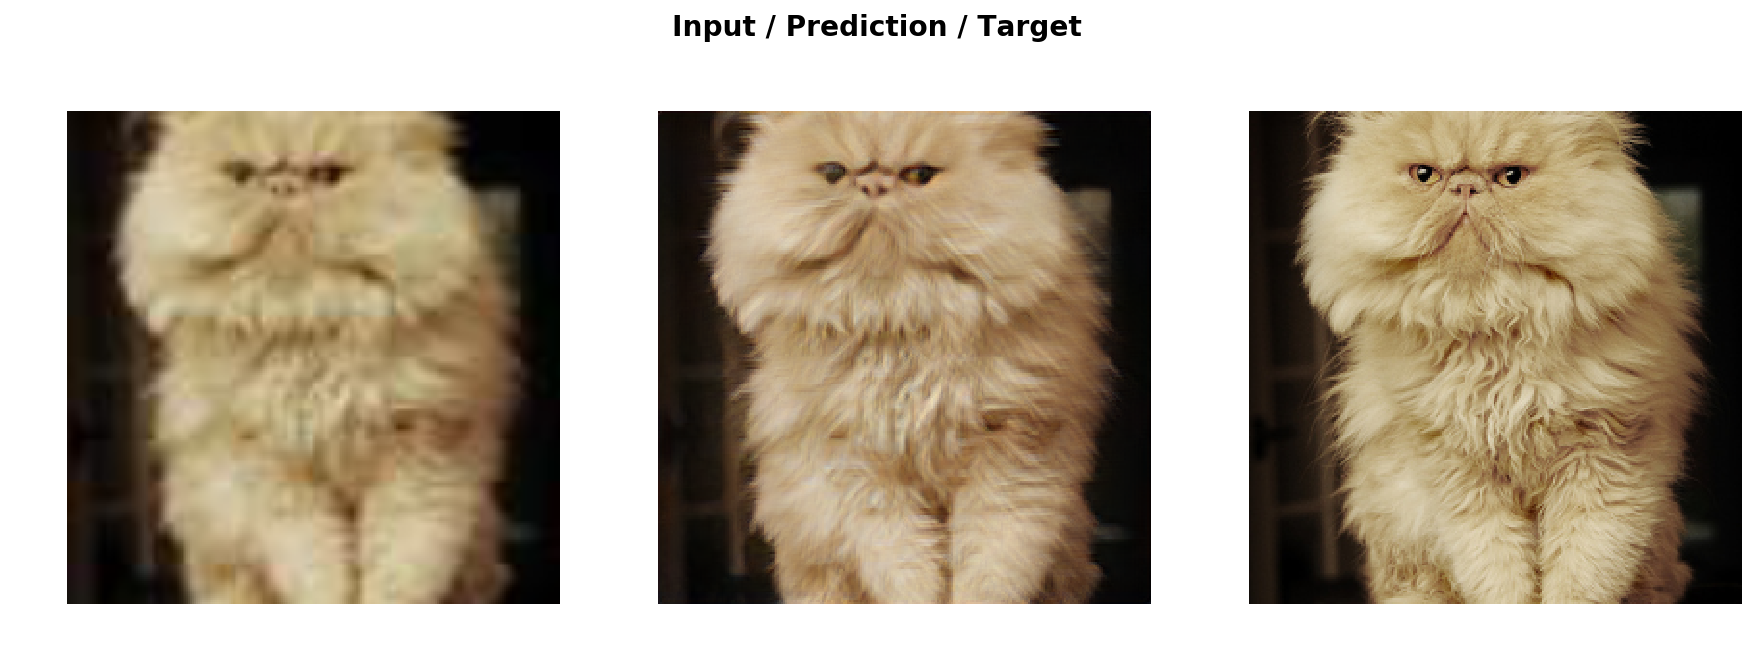

In [20]:
do_fit('2a')

Increasing our target image size to 256 px has helped our model learn to do an even better job of taking poor quality 96 px images and *enhancing* them.

We can now see greater definition in the fur and face in the `Prediction` cat image. 

But we can do even a bit better. Let's unfreeze the rest of the layers and train our all our network's weights using the 256 px target images.

In [21]:
learn.load('2a');

In [22]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.180553,2.077443,0.188226,0.255380,0.279682,0.144696,0.328833,0.541328,0.339298
2,2.179318,2.065116,0.176568,0.256056,0.280645,0.145316,0.325452,0.541300,0.339778
3,2.176883,2.053194,0.169257,0.255461,0.279741,0.144967,0.325842,0.538438,0.339488
4,2.155765,2.059108,0.175039,0.254554,0.279210,0.144553,0.327930,0.538972,0.338851
5,2.158400,2.081797,0.197199,0.255081,0.279523,0.144479,0.328453,0.538372,0.338691
6,2.167609,2.050157,0.174564,0.254491,0.278814,0.143864,0.325856,0.535381,0.337187
7,2.181143,2.048458,0.171214,0.254994,0.278997,0.144184,0.325285,0.536528,0.337255
8,2.183330,2.052696,0.175967,0.254300,0.278654,0.143843,0.326204,0.536719,0.337009
9,2.168781,2.047536,0.172747,0.254927,0.278725,0.144118,0.324838,0.535059,0.337122
10,2.146406,2.048090,0.172196,0.255229,0.279300,0.144283,0.323658,0.536178,0.337246


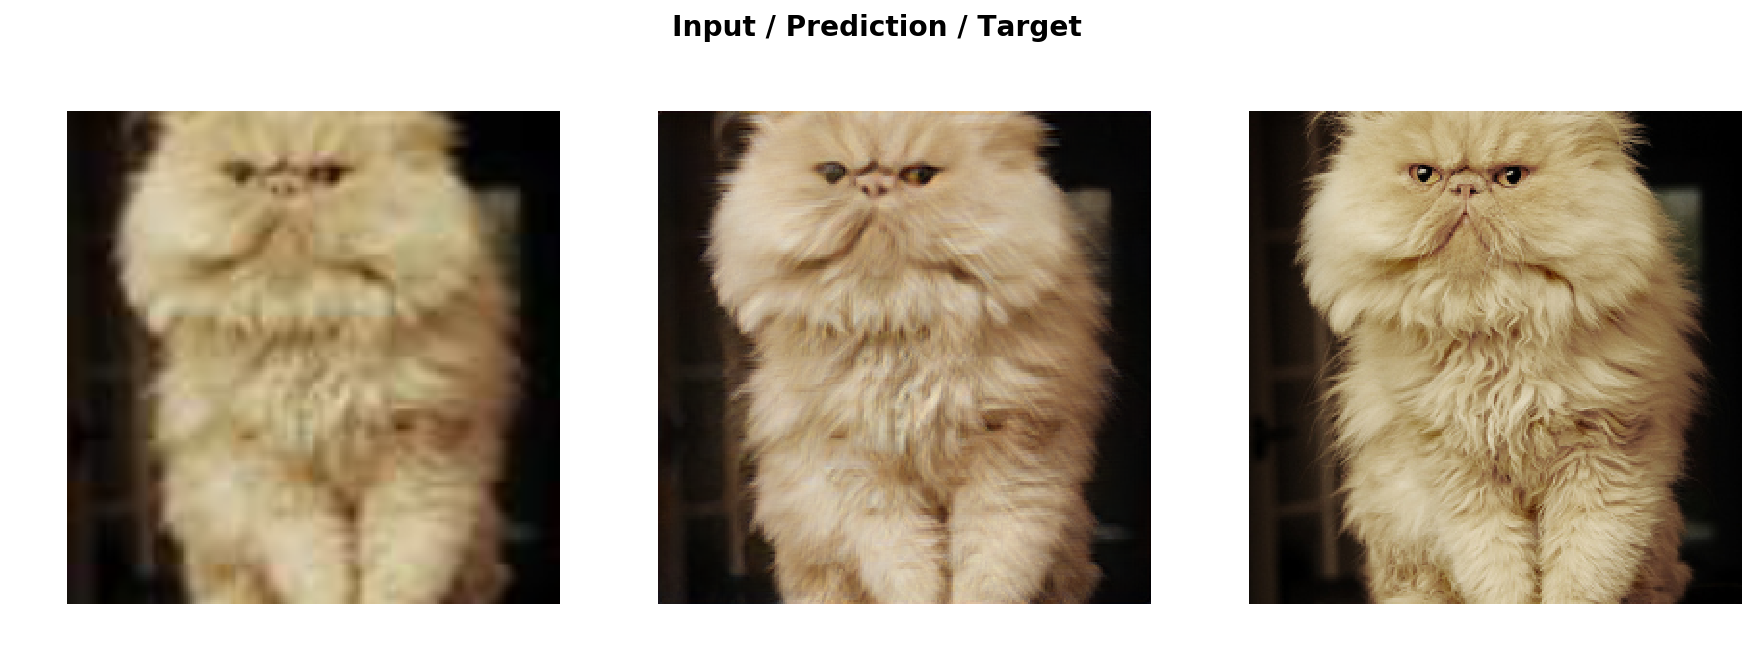

In [23]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

Our `Prediction` image quality has improved even further, with validation loss now below `2.05`.

We now know that our model is pretty adept at improving the clarity of 96 px sized images, at least being able to get them to look somewhat closer to a 256 px sized image. The final question is, however, whether or not our model will be able to take images of other resolutions and improver their quality. 

After all, in today's world of retina displays, what we really want would be a model that can scale an image's clarity and sharpness up much higher than a 256 px sized image.

## Putting our super resolution model to the test

To conclude this notebook, we'll attempt to use the model we just trained to scale our pet images up to a much higher resolution.

We'll first take some of the original high resolution pet images and scale them down to 256 px (similar to how we previously scaled them down to 96 px).

Then, we'll use the UNet we trained above to predict a high resolution version of the image from the scaled-down-to-256 input image.

In [27]:
il = ImageItemList.from_folder(path_hr)

In [30]:
def resize_two(fn, i):
    dest = path_mr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 256, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [31]:
# Uncomment if running this notebook for the first time.
# parallel(resize_two, il.items)

In [32]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(819,1024), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [34]:
learn.load('2b');

In [35]:
learn.data = data_mr

In [36]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-256/Persian_87.jpg')

Let's take a look at the 256 px scaled-down image that we will hopefully soon improve to a high resolution.

In [37]:
img = open_image(fn); img.shape

torch.Size([3, 385, 256])

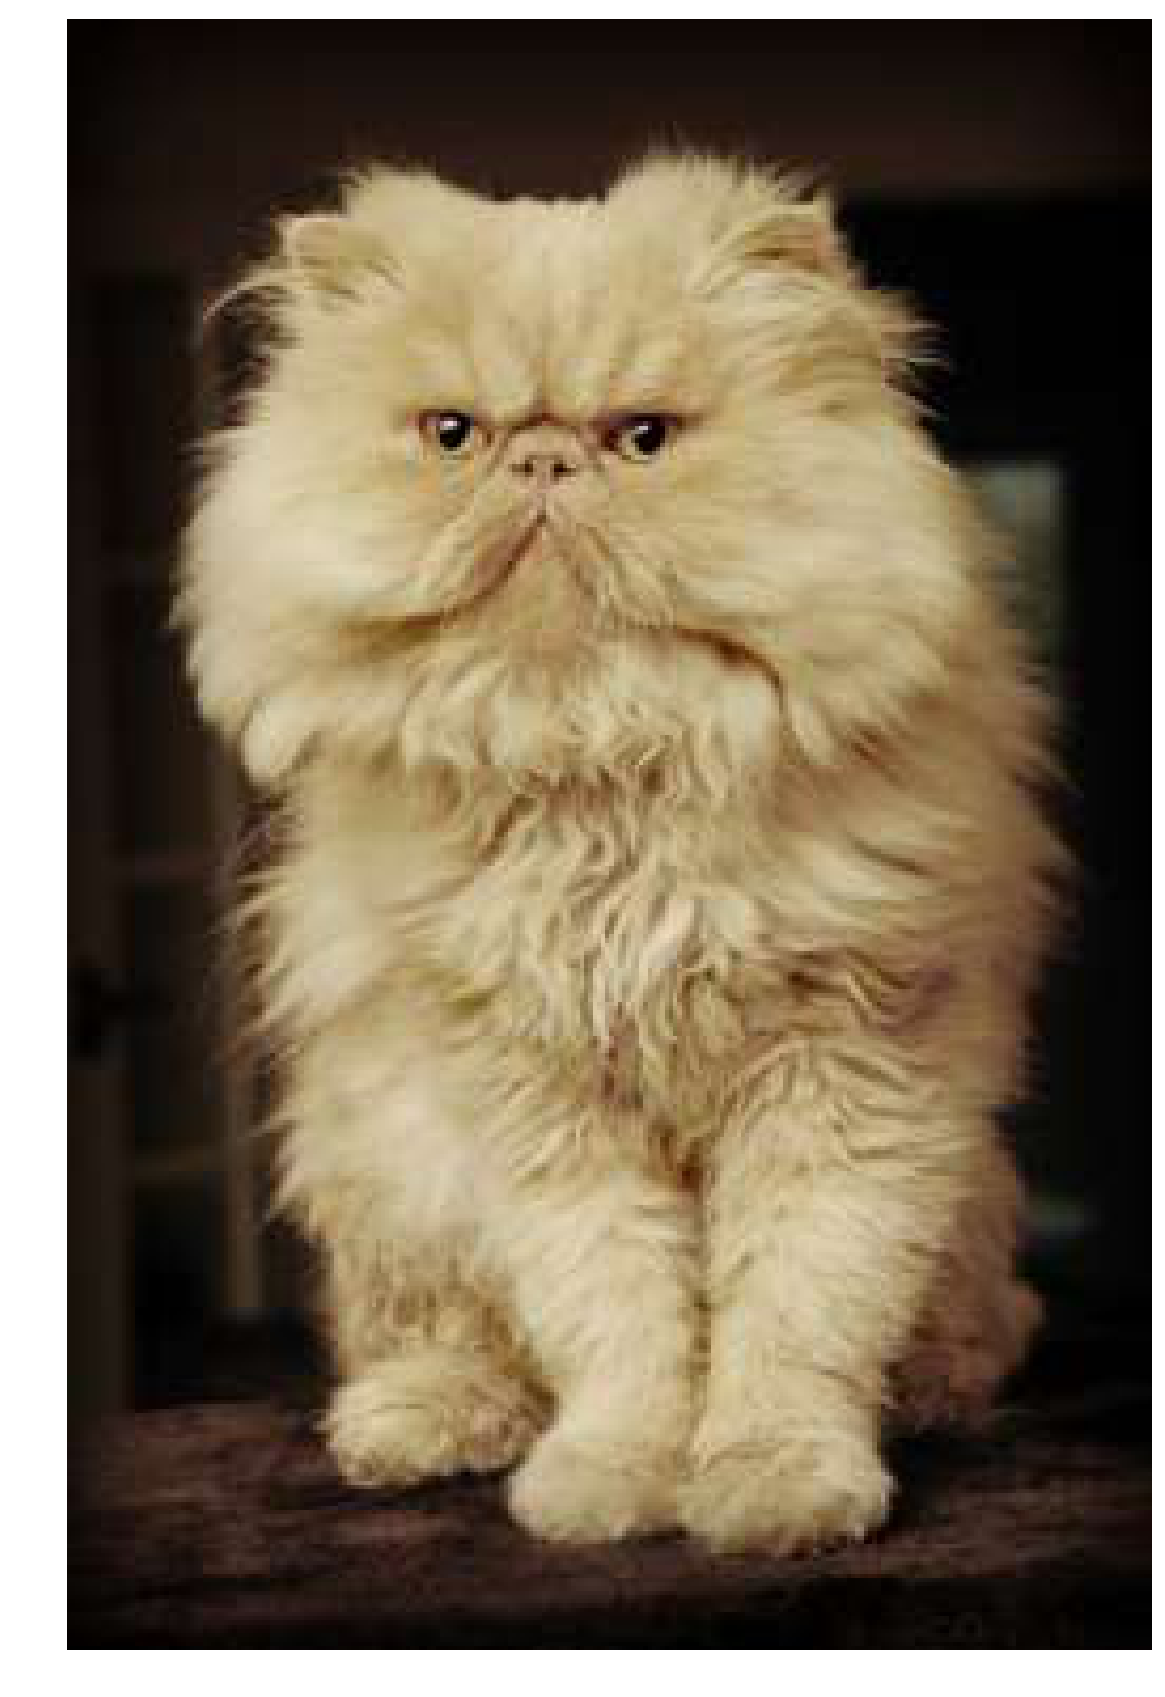

In [38]:
show_image(img, figsize=(18,15), interpolation='nearest');

Now for the grand finale -- let's see much the above image improves when we use our model to predict what high resolution version ought to look like.

In [39]:
_, img_hr, b = learn.predict(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


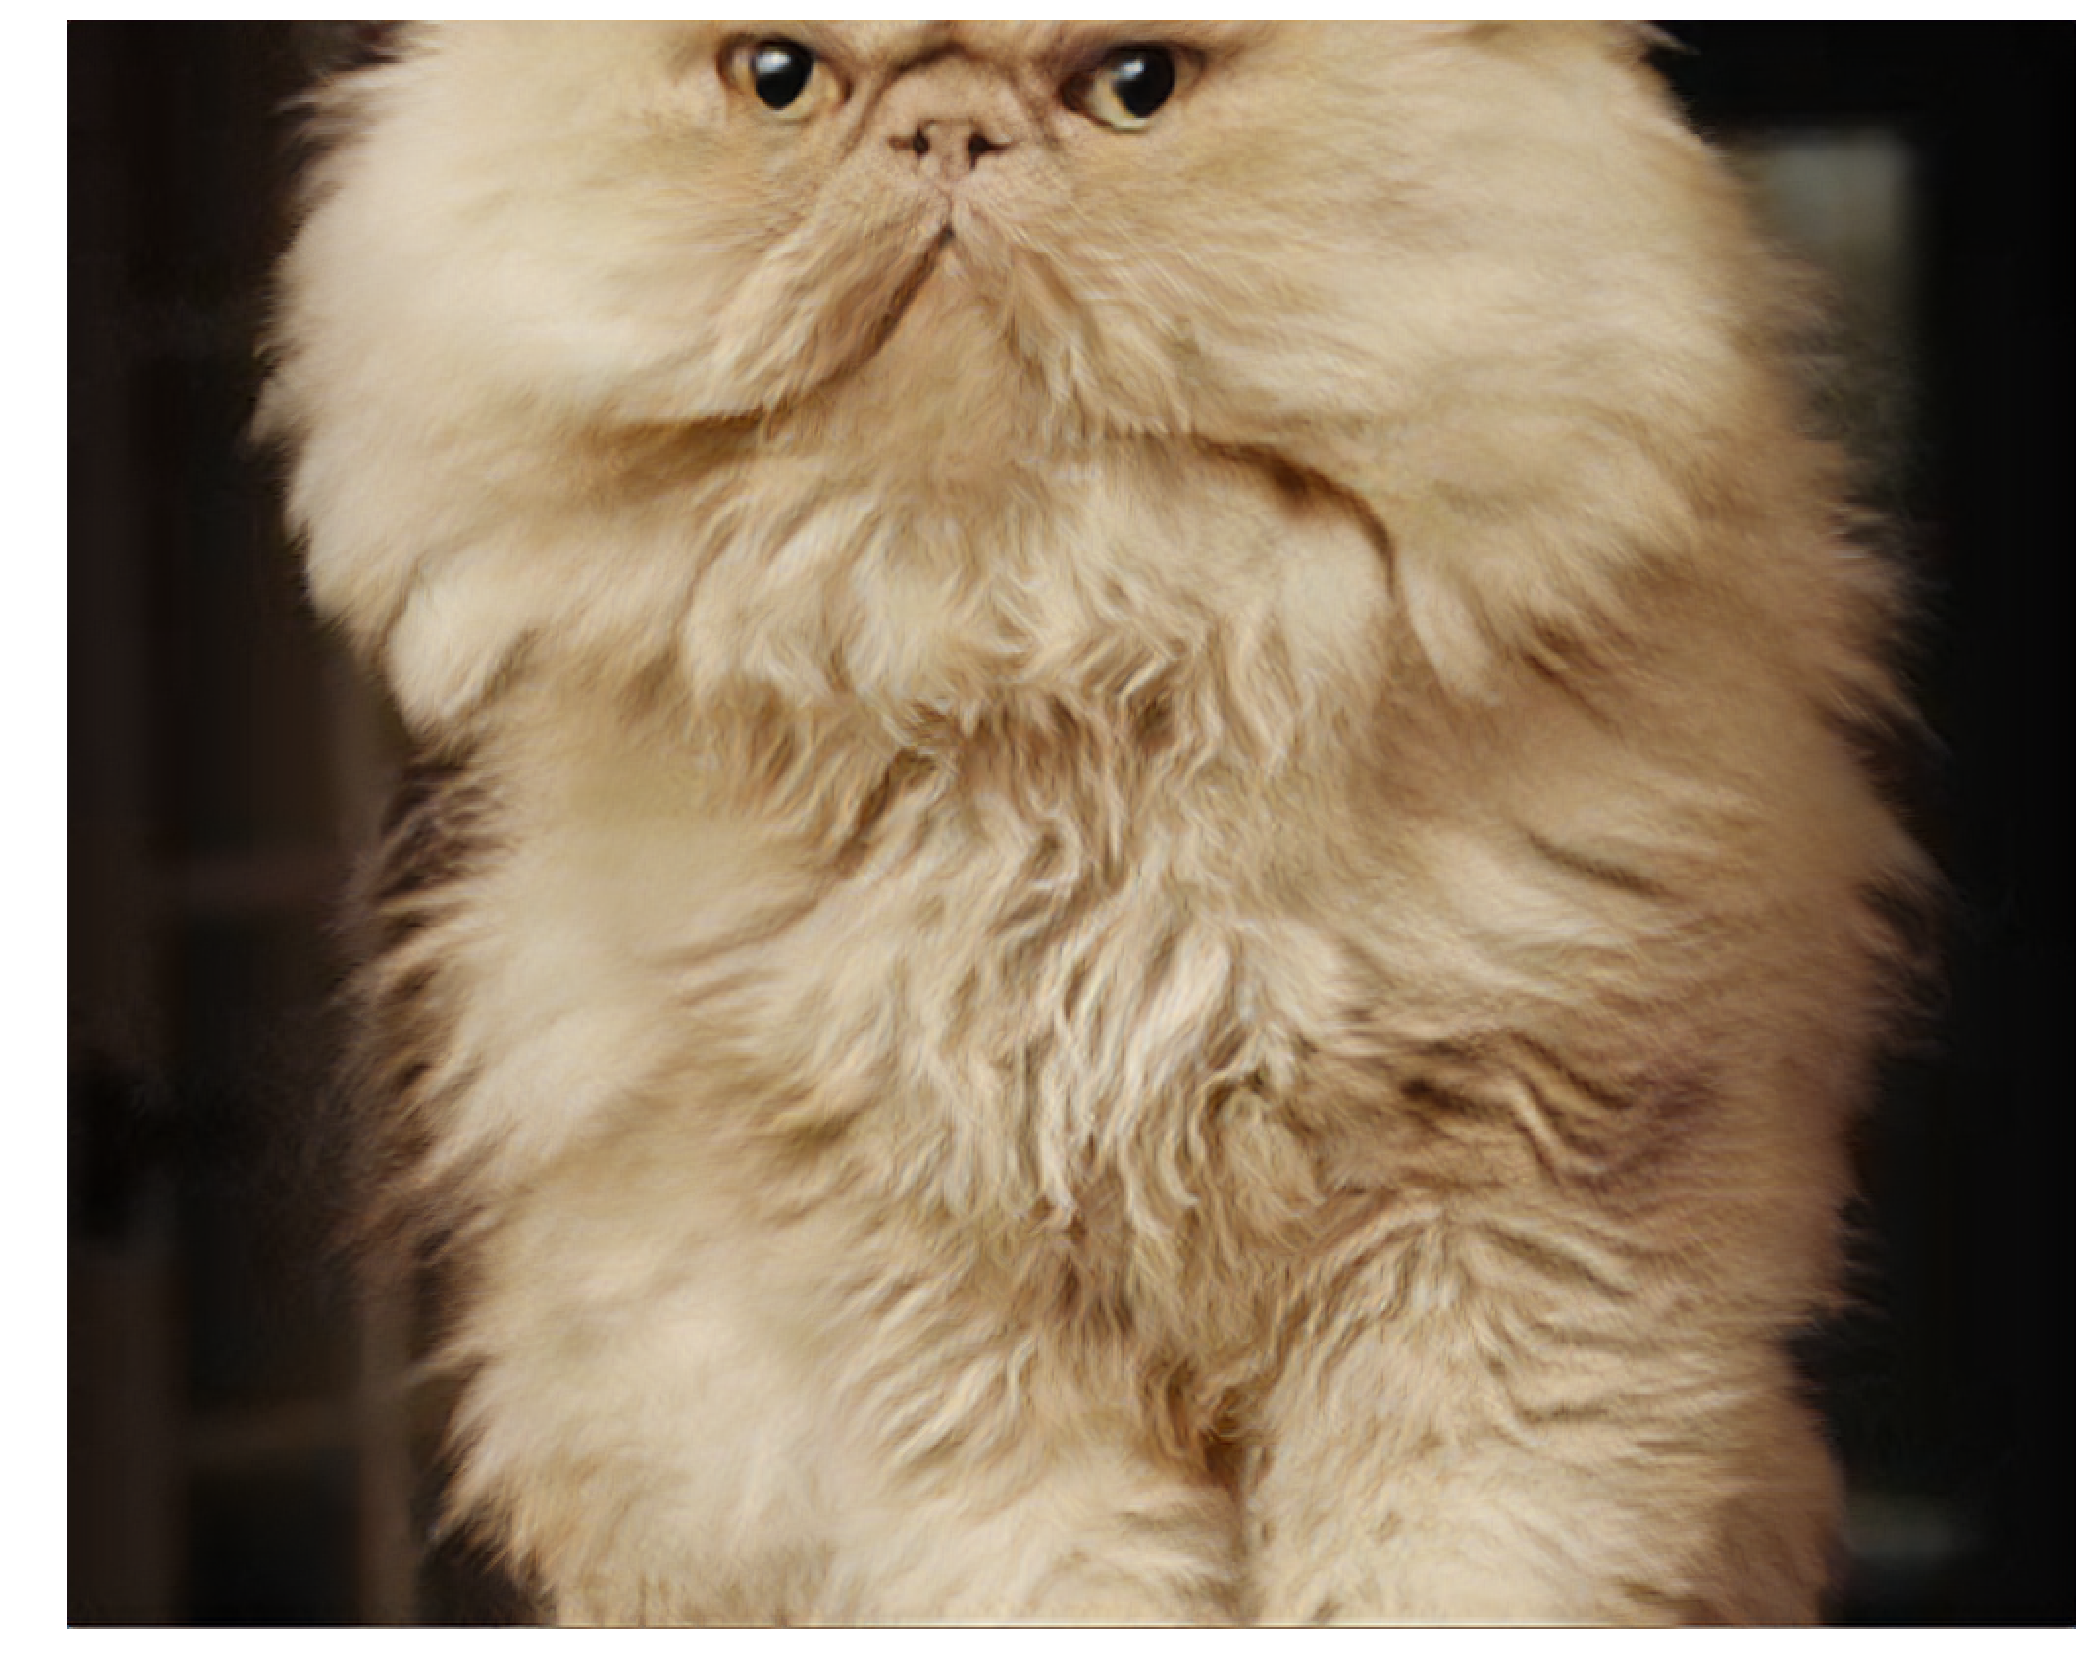

In [40]:
Image(img_hr).show(figsize=(18,15))

Absolutely astounding! Look at the definition in the cat's fur, and the sharpeness of the features in its face, its nose and eyes. Teaching the model how to scale from 96 px images to 128 px, and then to 256 px images enables our model to take even better input images and then transform them into unquestionably high resolution images!

The beauty is that we don't have to train using the higher quality images (eg. 256 px), and yet can still obtain a model that is more than capable of taking such images and turning them into finely-detailed, high-res images that look great on our retina displays.

Thanks to a combination of using a UNet architecture built on a pretrained network (ResNet34), a feature loss function that incorporates perceptual loss, and progressive resizing during training, we've built a model that is able to make seemingly miraculous improvements in the sharpness and definition of low-quality images of pets.